In [1]:
import random
import seaborn as sns
import torch
import numpy as np
from torch import nn, optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.distributions import Normal
import time 

In [2]:
# define the model for the Gaussian distribution
class GaussianDistributionModel(nn.Module):
    def __init__(self, mu_init: float, sigma_init: float):
        super(GaussianDistributionModel, self).__init__()
        self.mu = nn.Parameter(torch.tensor([mu_init]), requires_grad=True)
        self.sigma = nn.Parameter(torch.tensor([sigma_init]), requires_grad=True)

    def forward(self, x):
        return - torch.log((1 / (self.sigma * torch.sqrt(torch.tensor(2 * torch.pi))) * \
               torch.exp(-0.5 * ((x - self.mu) / self.sigma) ** 2)))

    def sample(self, num_samples: int):
        return self.mu + self.sigma * torch.randn(num_samples)

In [3]:
# define loss function converge to the energy discrepancy 
def ED(E_theta, samples, M, t , w):
    device = samples.device

    si_i = np.sqrt(t) * torch.randn_like(samples).to(device)
    si_ij = np.sqrt(t) * torch.randn(samples.size(0), M, *samples.shape[1:]).to(device)

    sum_part = samples.unsqueeze(1) + si_i.unsqueeze(1) + si_ij
    
    # compute the part of loss part
    E_1 = E_theta(samples.unsqueeze(1)).view(samples.size(0), -1)
    E_2 = E_theta(sum_part.view(-1, *samples.shape[1:])).view(samples.size(0), -1)

    # compute the loss in the sum part
    loss_i = E_1 - E_2
    
    if w != 0:
        loss_i = torch.cat([loss_i, np.log(w) * torch.ones_like(loss_i[:, :1])], dim=-1)
    
    # take the logsumexp step to compute the loss
    loss = loss_i.logsumexp(dim=-1).mean()

    return loss

In [4]:
# train the loop
def train(model, data, M, t, w, epochs, learning_rate=0.01):
    loss1 = []
    mu1 = []
    sigma1 = []
    step = []
    l2 = []

    time1 = time.time()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        optimizer.zero_grad()

        loss = ED(E_theta=model, samples=data, M=M, t=t, w=w)

        loss1.append(loss.item())
        mu1.append(model.mu.item())
        sigma1.append(model.sigma.item())

        sample_train = model.sample(data.size(0)).detach().numpy()
        MSE = ((sample_train - data.detach().numpy()) ** 2).mean()
        l2.append(MSE)

        loss.backward()
        optimizer.step()
        step.append(epoch)

    time2 = time.time()
    time_cost = time2 - time1

    return loss1, mu1, sigma1, step, time_cost, l2

In [5]:
# take all true values for the target distribution
true_mu = 2
true_sigma = 0.5
observed_data = np.random.normal(true_mu, true_sigma, 1000)
observed_data_tensor = torch.tensor(observed_data, dtype=torch.float32)

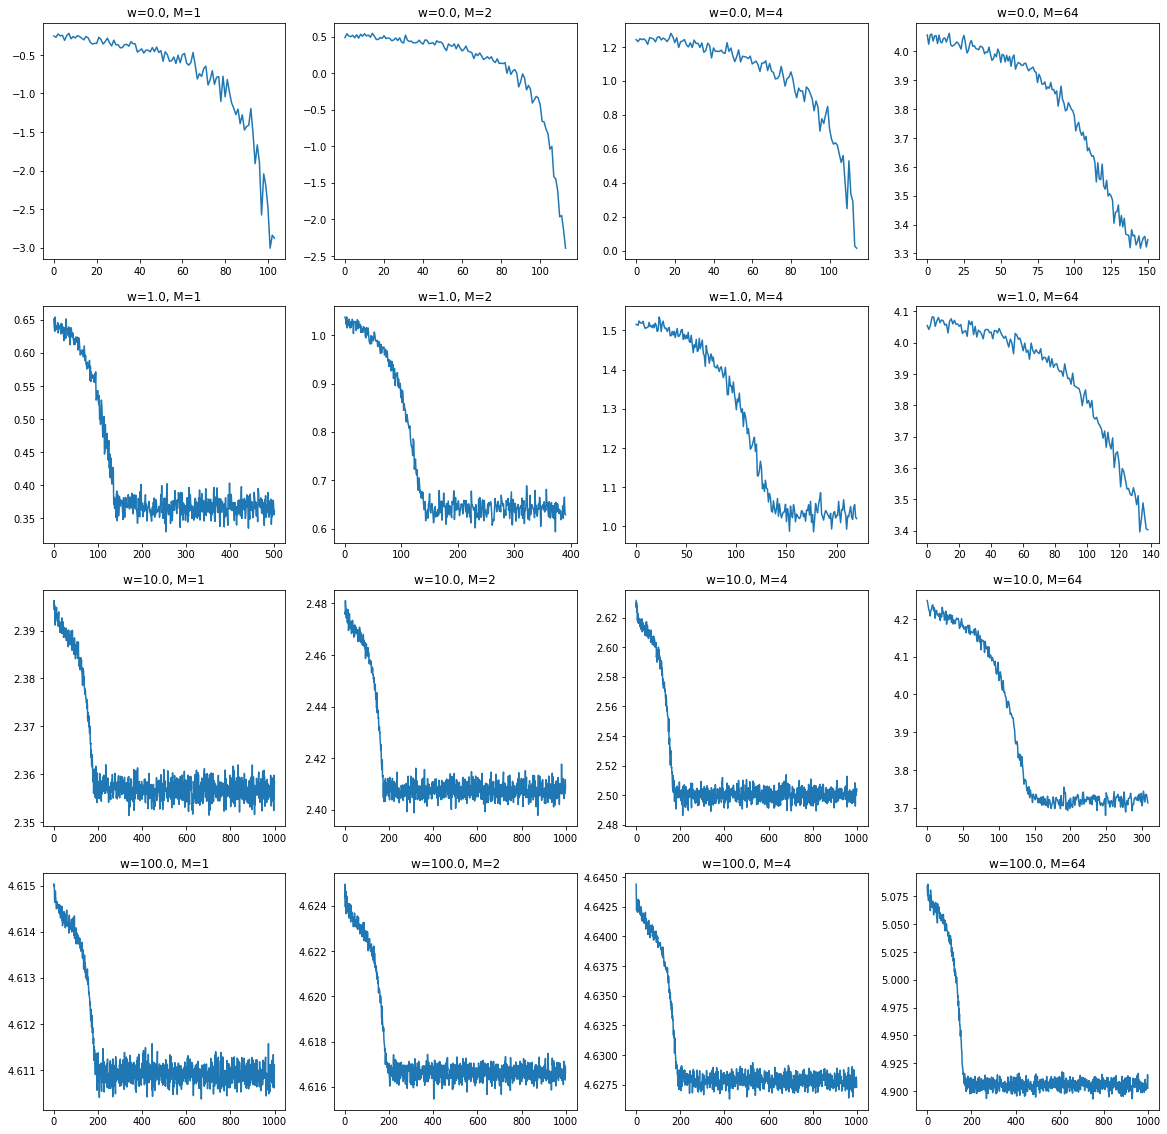

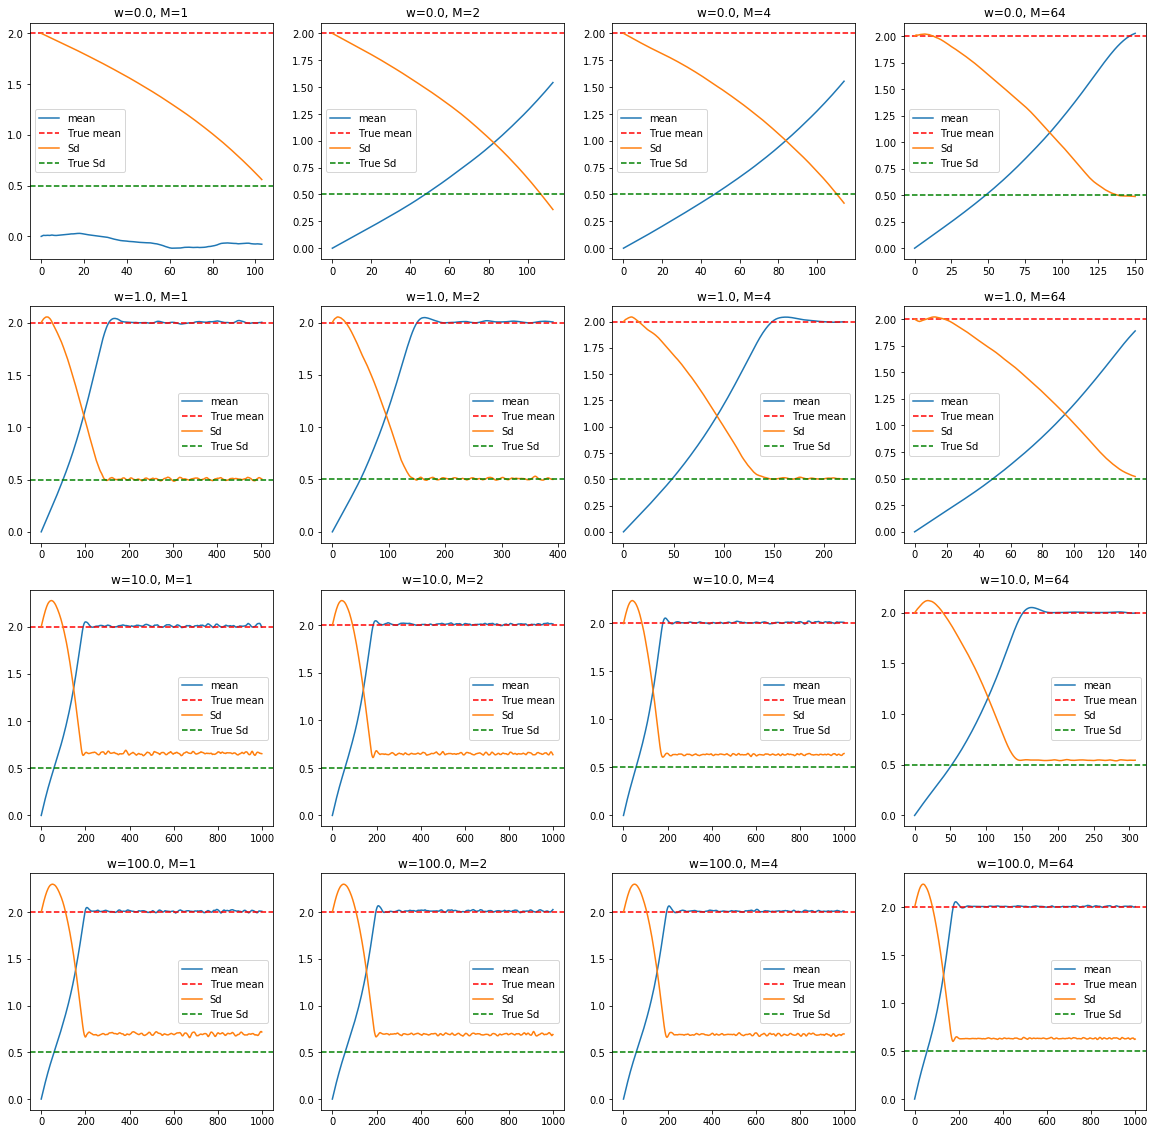

In [11]:
w = [0.0, 1.0, 10.0, 100.0]
M = [1, 2, 4, 64]
t = 1

fig,axs = plt.subplots(len(w), len(M), figsize=(20, 20))
fig_1,axs_1 = plt.subplots(len(w), len(M), figsize=(20, 20))

for i in range(len(w)):
    for j in range(len(M)):
        model = GaussianDistributionModel(mu_init=0.0, sigma_init=2.0)
        losses, mus_ED, sigmas_ED, step, computing_time, l2_log \
            = train(model, observed_data_tensor, M=M[j], t=t, w=w[i], epochs=1000)
        axs[i,j].plot((losses), label=f"w={w[i]}, M={M[j]}")
        axs[i,j].set_title(f"w={w[i]}, M={M[j]}")

        axs_1[i,j].plot((mus_ED), label=f"mean")
        axs_1[i,j].axhline(y=true_mu, color='r', linestyle='--', label='True mean')
        axs_1[i,j].plot((sigmas_ED), label=f"Sd")
        axs_1[i,j].axhline(y=true_sigma, color='g', linestyle='--', label='True Sd')
        axs_1[i,j].set_title(f"w={w[i]}, M={M[j]}")
        axs_1[i,j].legend()

fig.savefig('loss_ED_Compare_t=1.png')
fig_1.savefig('mu_sigma_ED_Compare_t=1.png')


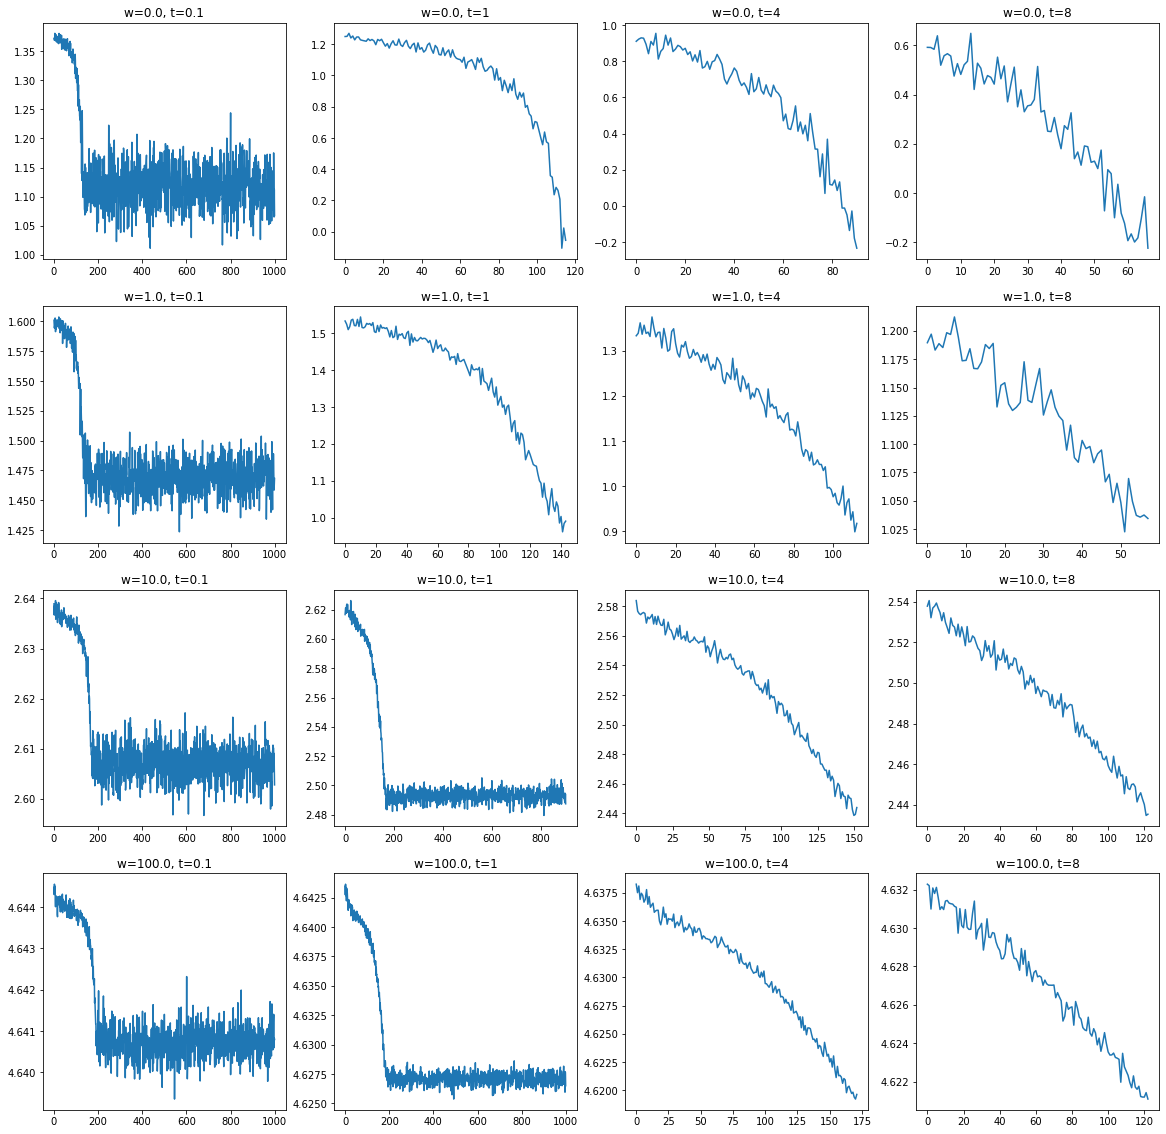

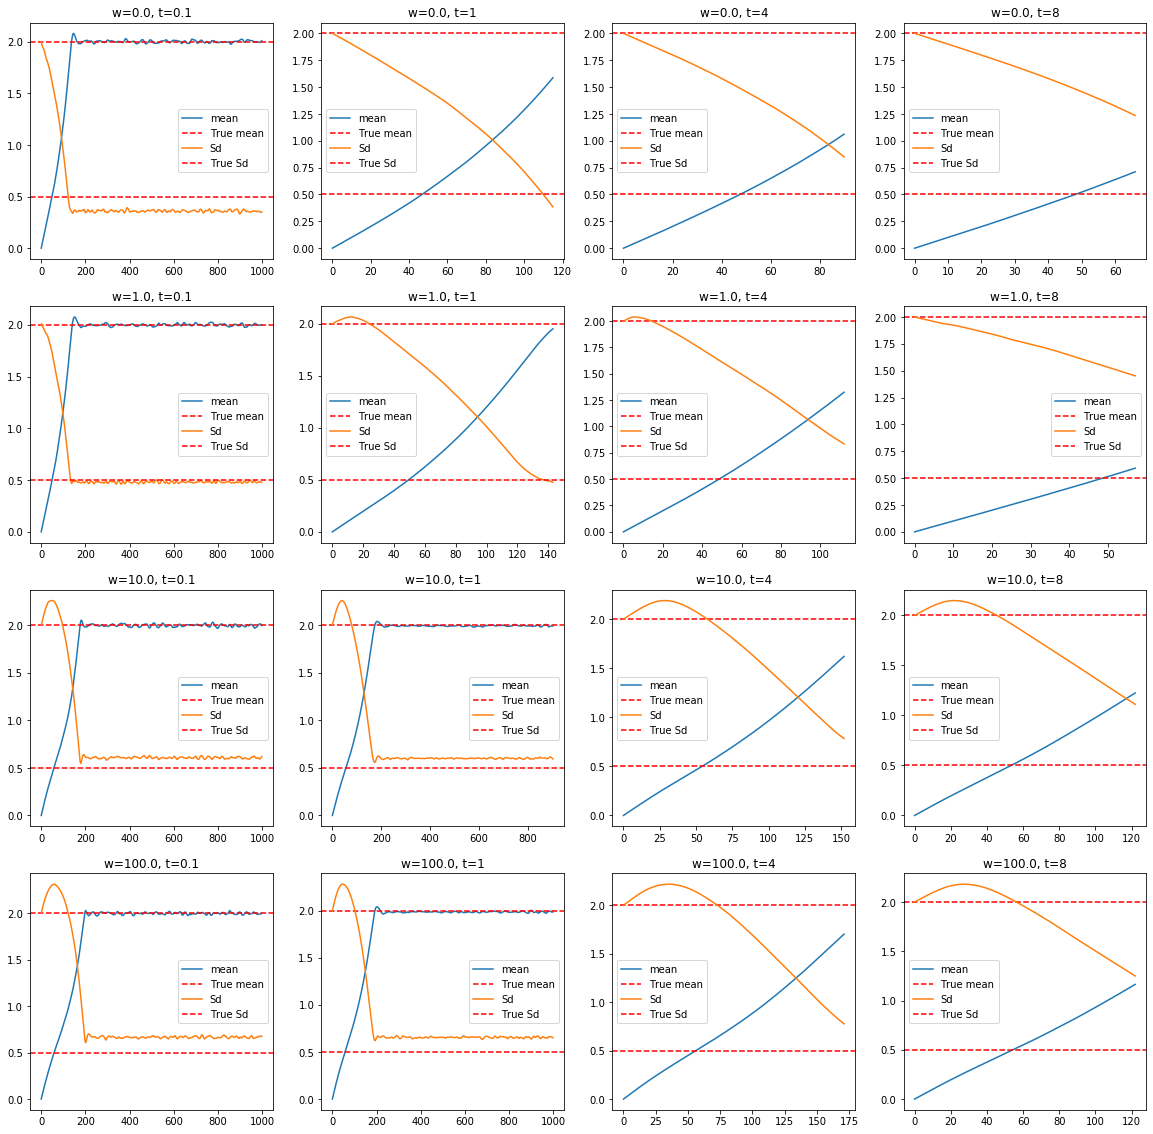

In [ ]:
w = [0.0, 1.0, 10.0, 100.0]
M = 4
t = [0.1, 1, 4, 8]

fig,axs = plt.subplots(len(w), len(t), figsize=(20, 20))
fig_1,axs_1 = plt.subplots(len(w), len(t), figsize=(20, 20))

for i in range(len(w)):
    for j in range(len(t)):
        model = GaussianDistributionModel(mu_init=0.0, sigma_init=2.0)
        losses, mus_ED, sigmas_ED, step, computing_time, l2_log \
            = train(model, observed_data_tensor, M=M, t=t[j], w=w[i], epochs=1000)
        axs[i,j].plot((losses), label=f"w={w[i]}, t={t[j]}")
        axs[i,j].set_title(f"w={w[i]}, t={t[j]}")

        axs_1[i,j].plot((mus_ED), label=f"mean")
        axs_1[i,j].axhline(y=true_mu, color='r', linestyle='--', label='True mean')
        axs_1[i,j].plot((sigmas_ED), label=f"Sd")
        axs_1[i,j].axhline(y=true_sigma, color='g', linestyle='--', label='True Sd')
        axs_1[i,j].set_title(f"w={w[i]}, t={t[j]}")
        axs_1[i,j].legend()

fig.savefig('loss_ED_Compare_M=4.png')
fig_1.savefig('mu_sigma_ED_Compare_M=4.png')

# 2D

In [12]:
# define the model for the Multivariate Gaussian distribution
class MultivariateGaussian(nn.Module):
    def __init__(self, mean: float, cov: float):
        super(MultivariateGaussian, self).__init__()
        self.mean = nn.Parameter(torch.tensor([mean]).squeeze(), requires_grad=True)
        self.cov = nn.Parameter(torch.tensor([cov]).squeeze(), requires_grad=True)
        self.dim = self.mean.shape[-1]

    def forward(self, x):
        cov_matrix = self.cov.view(self.dim, self.dim)
        cov_matrix = cov_matrix @ cov_matrix.T + torch.eye(self.dim) * 1e-6
        self.inv_cov = torch.inverse(cov_matrix)
        self.det_cov = torch.det(cov_matrix)
        self.norm_const = 1.0 / torch.sqrt((2 * np.pi) ** self.dim * self.det_cov)
        x = x.float()
        diff = x - self.mean
        exponent = -0.5 * torch.sum(diff @ self.inv_cov * diff, dim=1)
        return - torch.log(self.norm_const * torch.exp(exponent))

    def sample(self, num_samples: int):
        # ensure the covariance matrix is positive definite
        cov = self.cov
        cov = cov @ cov.T
        samples = self.mean + torch.randn(num_samples, self.dim) @ torch.linalg.cholesky(cov)
        return samples

In [13]:
# train the loop
def train(model, data, M, t, w, epochs=1000, learning_rate=0.1):
    loss1 = []
    mu1 = []
    mu2 = []
    sigma1 = []
    step = []
    
    time1 = time.time()

    # gradient descent
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        optimizer.zero_grad()

        loss = ED(E_theta=model, samples=data, M=M, t=t, w=w)
        
        mu_1 = model.mean[0].item()
        cov_1 = model.cov[0][0].item()

        loss1.append(loss.item())
        mu1.append(mu_1)
        mu2.append(model.mean[1].item())
        sigma1.append(cov_1)

        loss.backward()
        optimizer.step()
        step.append(epoch)

    time2 = time.time()

    return loss1, mu1, mu2, sigma1, step, time2-time1

In [14]:
# define loss function converge to the energy discrepancy 
def ED(E_theta, samples, M, t, w):
    device = samples.device

    si_i = np.sqrt(t) * torch.randn_like(samples).to(device)
    si_ij = np.sqrt(t) * torch.randn(samples.size(0), M, *samples.shape[1:]).to(device)

    sum_part = samples.unsqueeze(1) + si_i.unsqueeze(1) + si_ij
    
    # compute the part of loss part
    E_1 = E_theta(samples).view(samples.size(0), -1)
    E_2 = E_theta(sum_part.view(-1, *samples.shape[1:])).view(samples.size(0), -1)

    # compute the loss in the sum part
    loss_i = E_1 - E_2
    
    if w != 0:
        loss_i = torch.cat([loss_i, np.log(w) * torch.ones_like(loss_i[:, :1])], dim=-1)
    
    # take the logsumexp step to compute the loss
    loss = loss_i.logsumexp(dim=-1).mean()
    return loss

In [15]:
# define the target model for the multivariate Gaussian distribution
true_mu2D = [0.0, 0.0]
true_sigma2D = [[1.0, 0.0], [0.0, 1.0]]
observed_data2D = MultivariateGaussian(mean=true_mu2D, cov=true_sigma2D).sample(1000).detach().numpy()
observed_data_tensor2D = torch.tensor(observed_data2D, dtype=torch.float32)

# initilaize the model
mu_init2D = [-4.0, 3.0]
sigma_init2D = [[3.0, 0.0], [0.0, 3.0]]

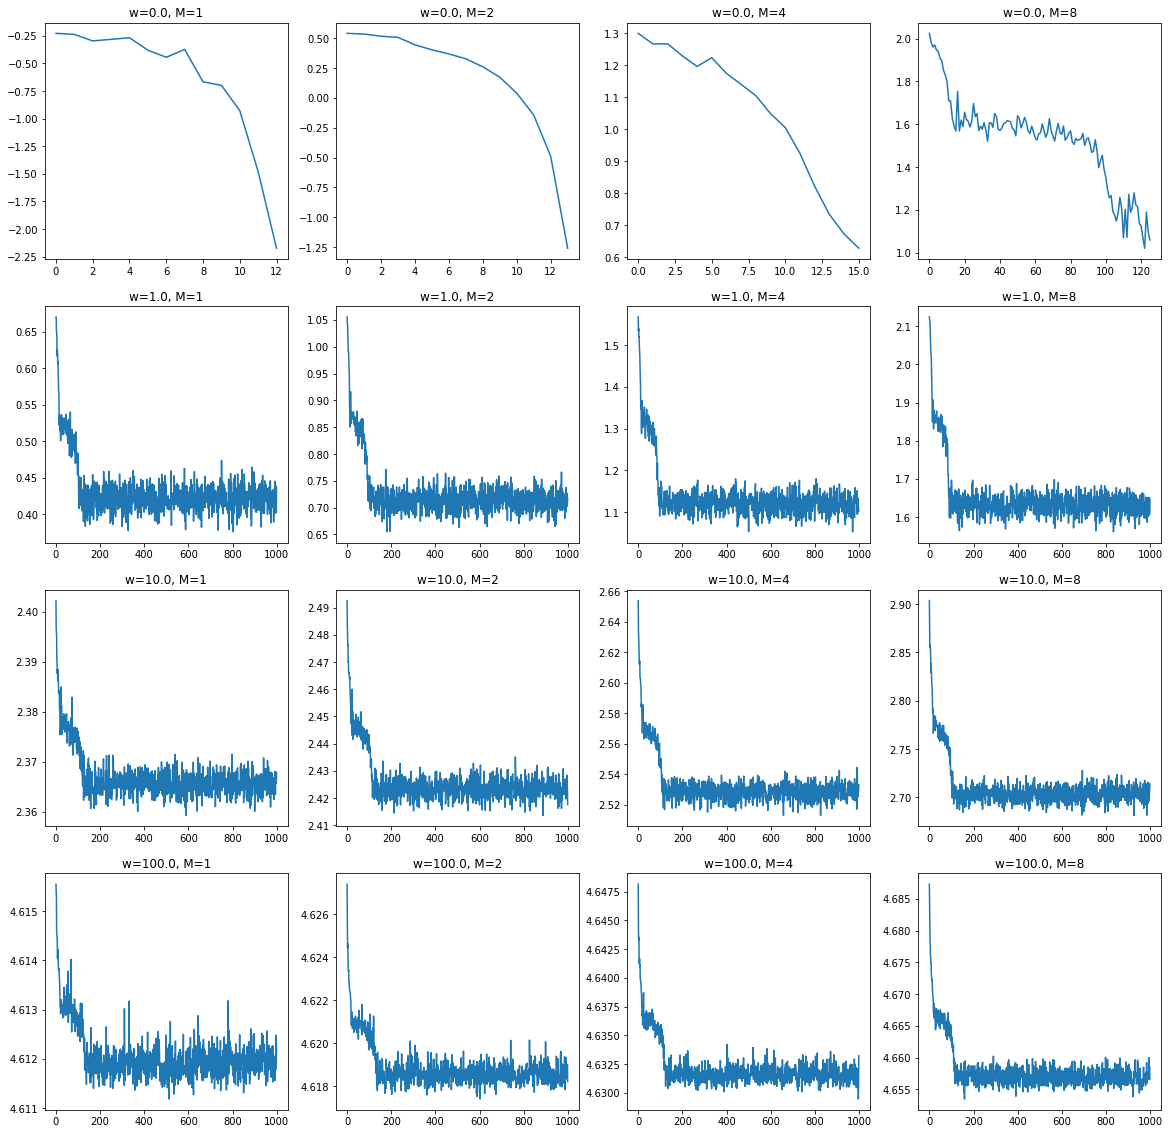

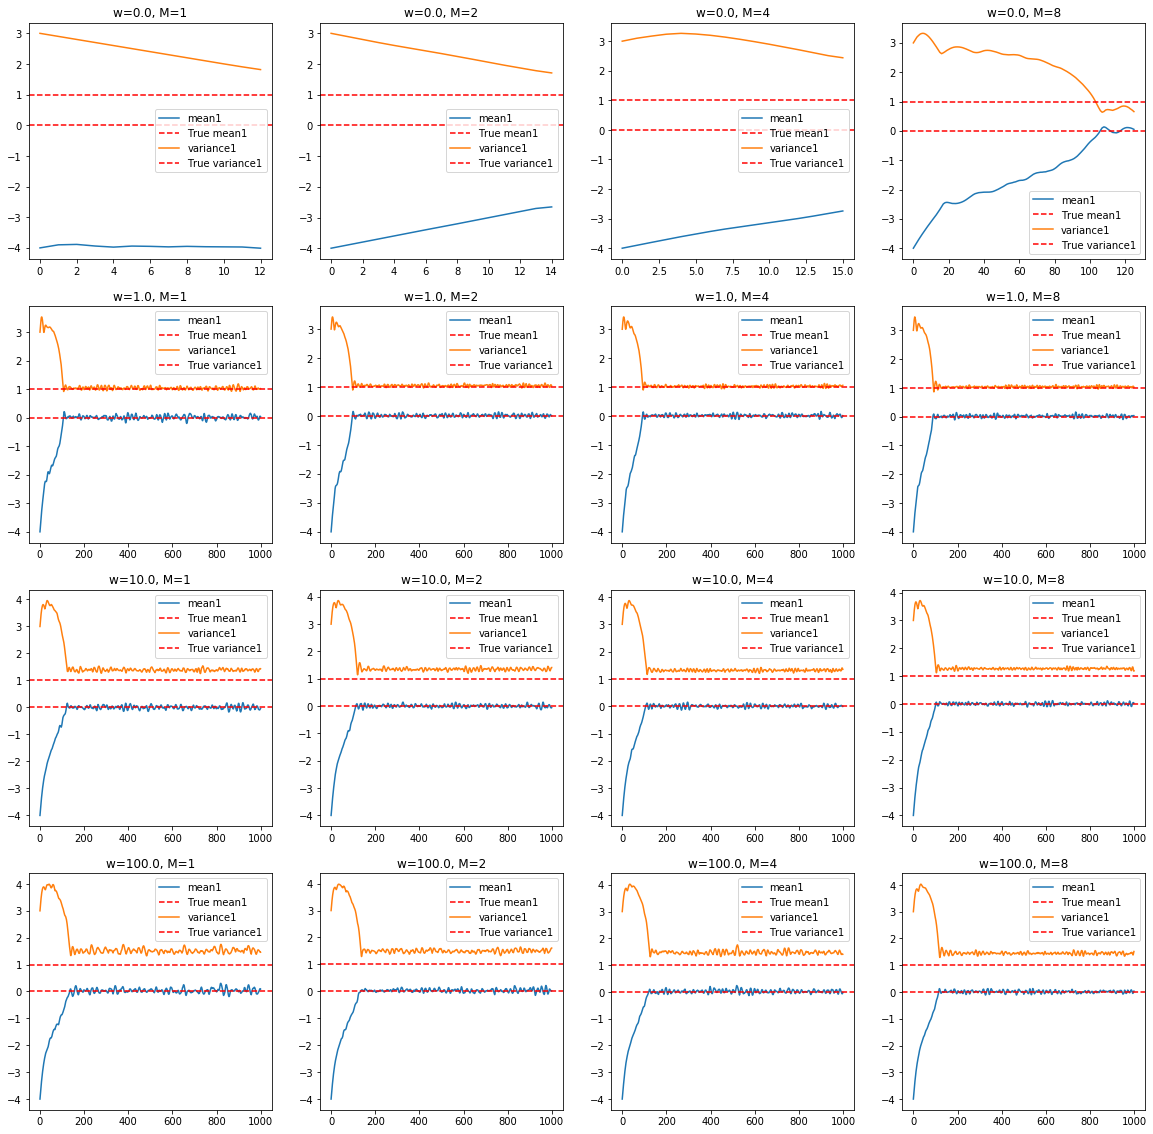

In [88]:
w = [0.0, 1.0, 10.0, 100.0]
M = [1, 2, 4, 8]
t = 1

fig,axs = plt.subplots(len(w), len(M), figsize=(20, 20))
fig_1,axs_1 = plt.subplots(len(w), len(M), figsize=(20, 20))

for i in range(len(w)):
    for j in range(len(M)):
        model_2D = MultivariateGaussian(mu_init2D, sigma_init2D)
        losses_2D, mus1_2DED, mus2_2DED, sigmas_2DED, step, computing_time \
            = train(model_2D, observed_data_tensor2D, M=M[j], t=t, w=w[i], epochs=1000)
        axs[i,j].plot((losses_2D), label=f"w={w[i]}, M={M[j]}")
        axs[i,j].set_title(f"w={w[i]}, M={M[j]}")

        axs_1[i,j].plot((mus1_2DED), label=f"mean1")
        axs_1[i,j].axhline(y=true_mu2D[0], color='r', linestyle='--', label='True mean1')
        axs_1[i,j].plot((sigmas_2DED), label=f"variance1")
        axs_1[i,j].axhline(y=true_sigma2D[0][0], color='g', linestyle='--', label='True variance1')
        axs_1[i,j].set_title(f"w={w[i]}, M={M[j]}")

fig.savefig('loss_2DED_Compare_t=1.png')
fig_1.savefig('mu_sigma_2DED_Compare_t=1.png')


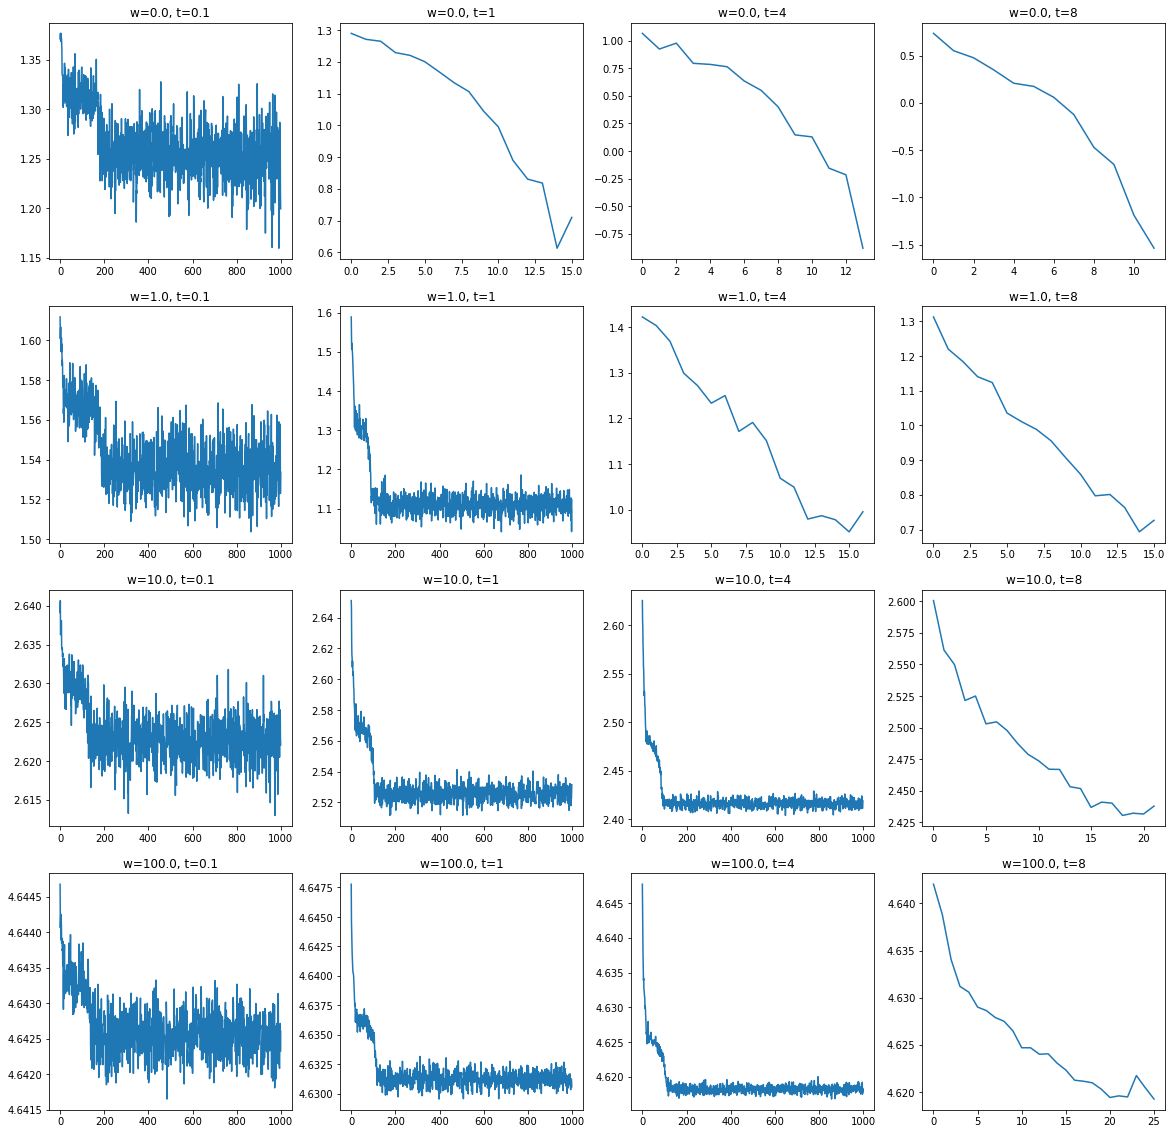

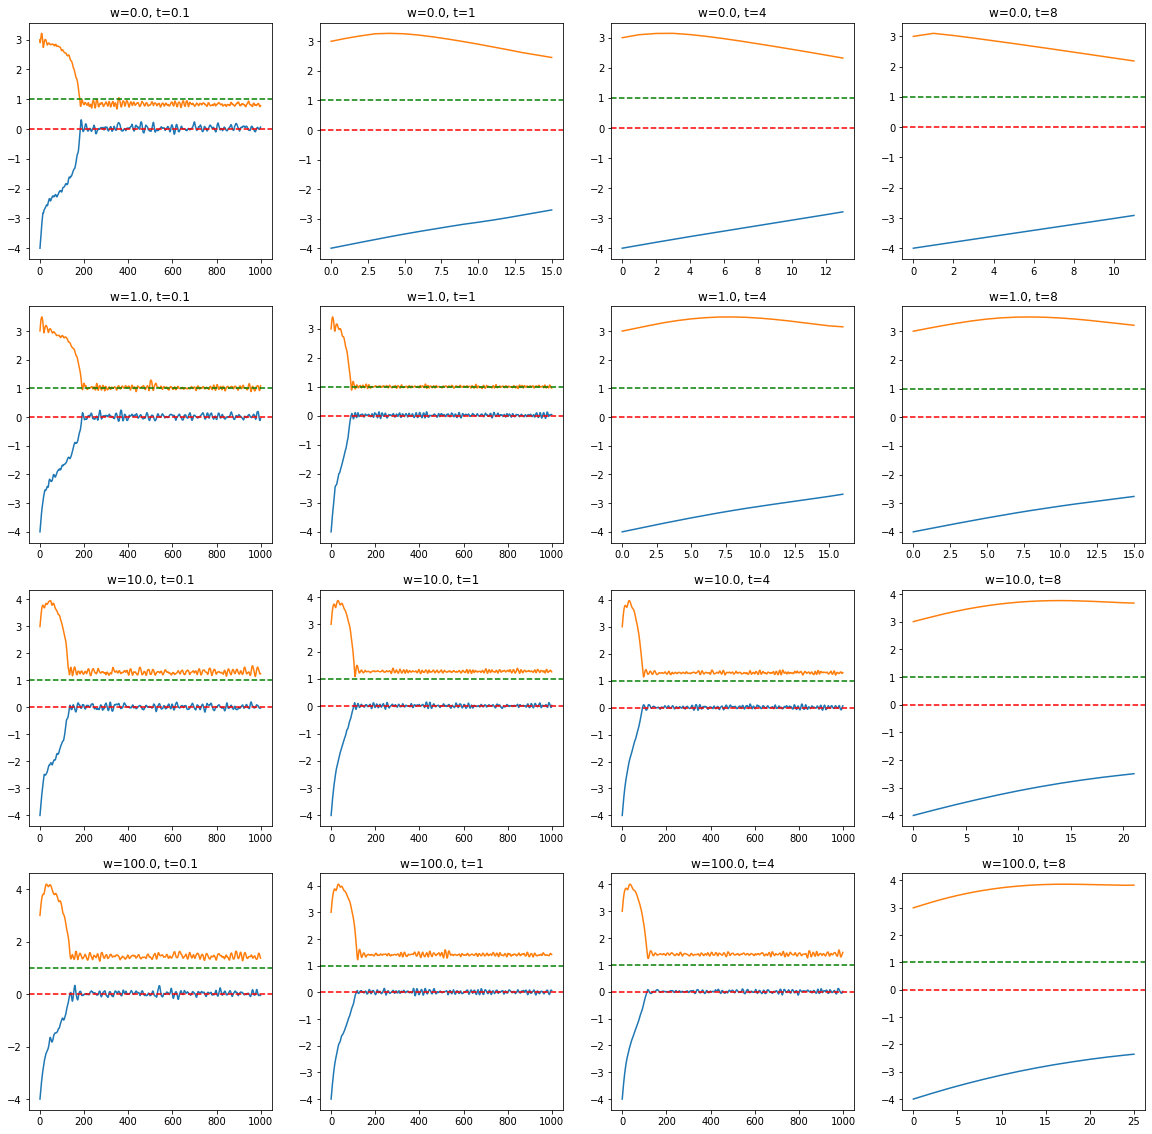

In [21]:
w = [0.0, 1.0, 10.0, 100.0]
M = 4
t = [0.1, 1, 4, 8]

fig,axs = plt.subplots(len(w), len(t), figsize=(20, 20))
fig_1,axs_1 = plt.subplots(len(w), len(t), figsize=(20, 20))

for i in range(len(w)):
    for j in range(len(t)):
        model_2D = MultivariateGaussian(mu_init2D, sigma_init2D)
        losses_2D, mus1_2DED, mus2_2DED, sigmas_2DED, step, computing_time \
            = train(model_2D, observed_data_tensor2D, M=M, t=t[j], w=w[i], epochs=1000)
        axs[i,j].plot((losses_2D), label=f"w={w[i]}, t={t[j]}")
        axs[i,j].set_title(f"w={w[i]}, t={t[j]}")

        axs_1[i,j].plot((mus1_2DED), label=f"mean1")
        axs_1[i,j].axhline(y=true_mu2D[0], color='r', linestyle='--', label='True mean1')
        axs_1[i,j].plot((sigmas_2DED), label=f"variance1")
        axs_1[i,j].axhline(y=true_sigma2D[0][0], color='g', linestyle='--', label='True variance1')
        axs_1[i,j].set_title(f"w={w[i]}, t={t[j]}")

fig.savefig('loss_2DED_Compare_M=4.png')
fig_1.savefig('mu_sigma_2DED_Compare_M=4.png')


# all parameters compared

In [140]:
# train the loop
def train_all(model, data, M, t, w, epochs=1000, learning_rate=0.1):
    loss1 = []
    mu1 = []
    mu2 = []
    sigma00 = []
    sigma01 = []
    sigma10 = []
    sigma11 = []
    step = []
    
    time1 = time.time()

    # gradient descent
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        optimizer.zero_grad()

        loss = ED(E_theta=model, samples=data, M=M, t=t, w=w)
        
        mu_1 = model.mean[0].item()
        cov_00 = model.cov[0][0].item()
        cov_01 = model.cov[0][1].item()
        cov_10 = model.cov[1][0].item()
        cov_11 = model.cov[1][1].item()

        loss1.append(loss.item())
        mu1.append(mu_1)
        mu2.append(model.mean[1].item())
        sigma00.append(cov_00)
        sigma01.append(cov_01)
        sigma10.append(cov_10)
        sigma11.append(cov_11)

        loss.backward()
        optimizer.step()
        step.append(epoch)

    time2 = time.time()

    return loss1, mu1, mu2, sigma00, sigma01, sigma10, sigma11, step, time2-time1

In [158]:
# define the target model for the multivariate Gaussian distribution
true_mu2D = [1.0, 2.0]
true_sigma2D = [[1.0, 0.0], [0.0, 1.0]]
observed_data2D = MultivariateGaussian(mean=true_mu2D, cov=true_sigma2D).sample(1000).detach().numpy()
observed_data_tensor2D = torch.tensor(observed_data2D, dtype=torch.float32)


# initilaize the model
mu_init2D = [-4.0, 3.0]
sigma_init2D = [[2.0, 1.0], [1.0, 2.0]]

M = 4
t = 1
w = 10.0

model_2D = MultivariateGaussian(mu_init2D, sigma_init2D)
A = train_all(model_2D, observed_data_tensor2D, M=M, t=t, w=w, epochs=100000)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  


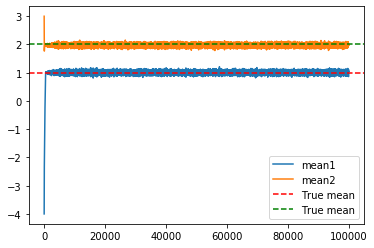

In [159]:
plt.plot(A[1], label='mean1')
plt.plot(A[2], label='mean2')
plt.axhline(y=true_mu2D[0], color='r', linestyle='--', label='True mean')
plt.axhline(y=true_mu2D[1], color='g', linestyle='--', label='True mean')
plt.legend()
plt.savefig('mean100000_amount')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  import sys


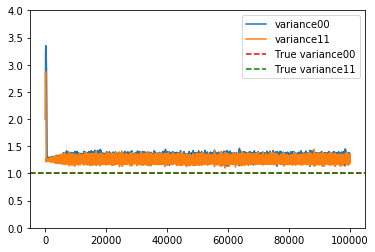

In [163]:
plt.plot(A[3], label='variance00')
plt.plot(A[6], label='variance11')
plt.axhline(y=true_sigma2D[0][0], color='r', linestyle='--', label='True variance00')
plt.axhline(y=true_sigma2D[1][1], color='g', linestyle='--', label='True variance11')
plt.ylim(0,4)
plt.legend()
plt.savefig('variance100000_amount')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  


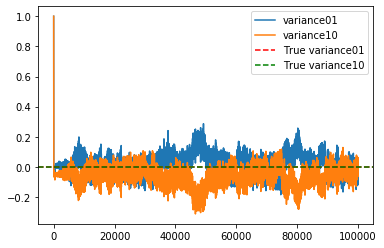

In [161]:
plt.plot(A[4], label='variance01')
plt.plot(A[5], label='variance10')
plt.axhline(y=true_sigma2D[0][1], color='r', linestyle='--', label='True variance01')
plt.axhline(y=true_sigma2D[1][0], color='g', linestyle='--', label='True variance10')
plt.legend()
plt.savefig('covariance100000_amount')